In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:08<00:00, 226.20it/s]


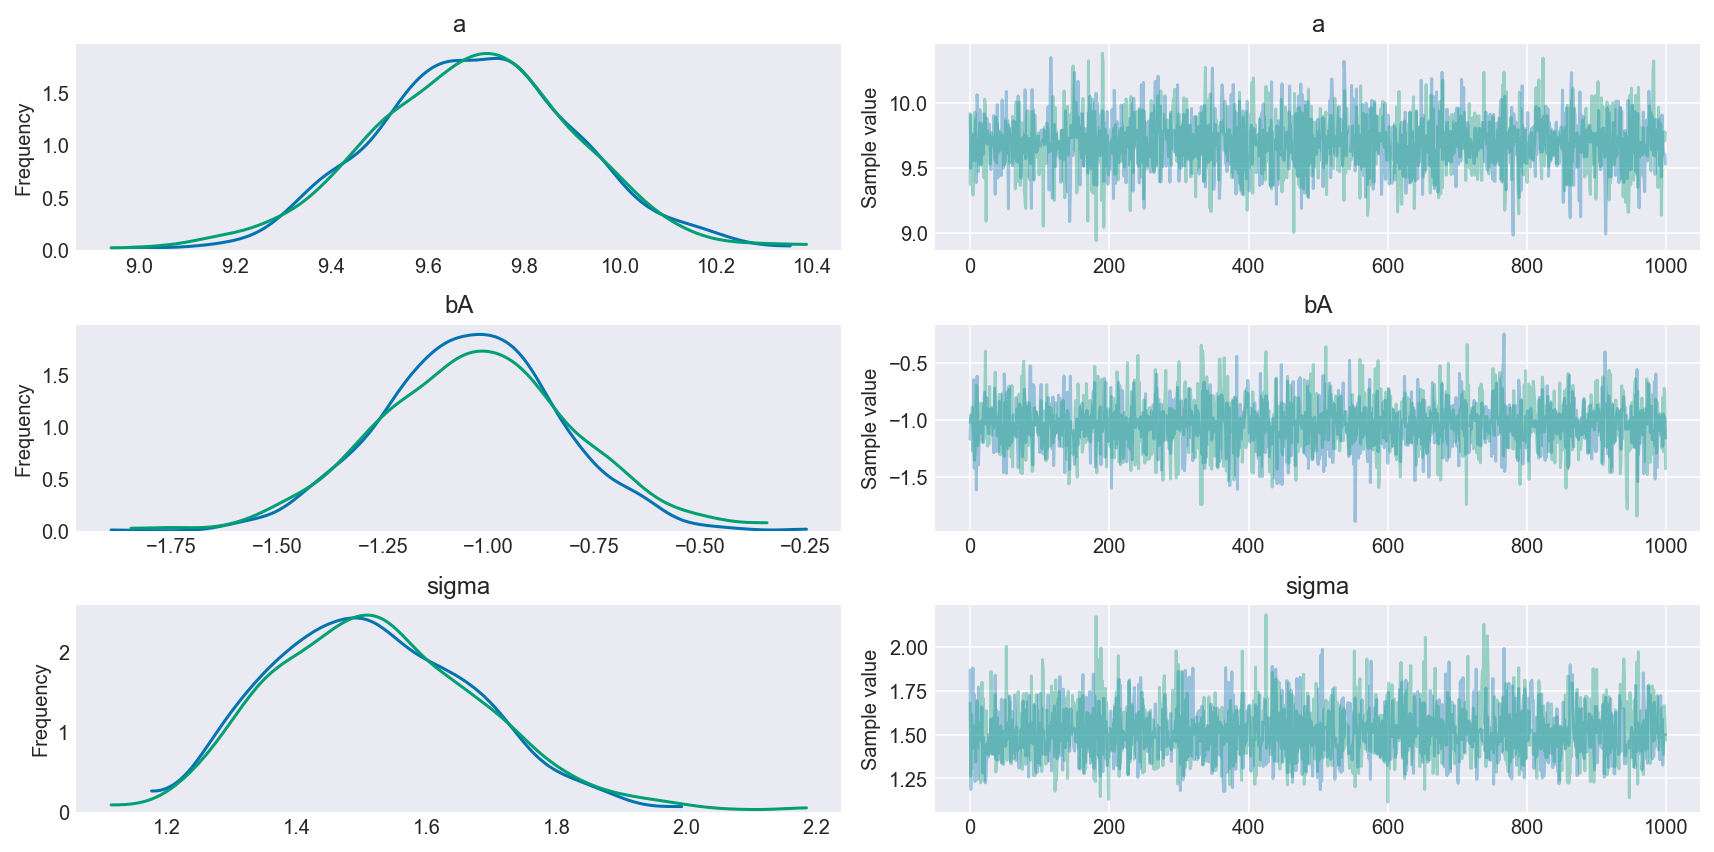

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

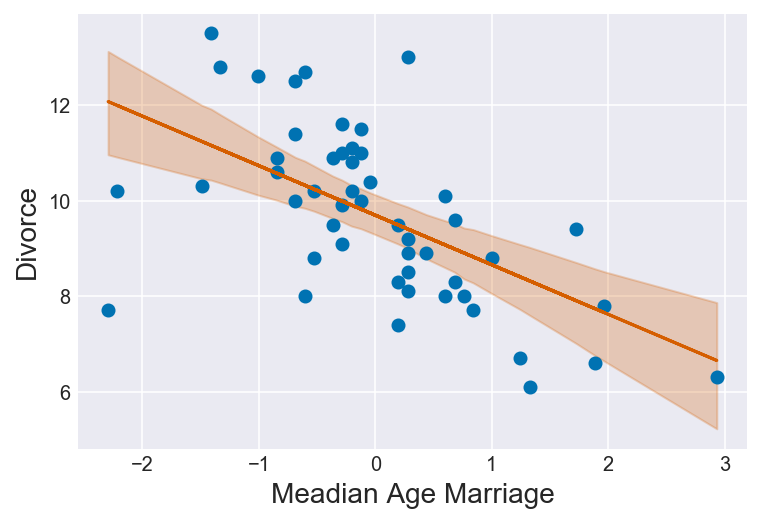

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [6]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [7]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 618.72it/s]


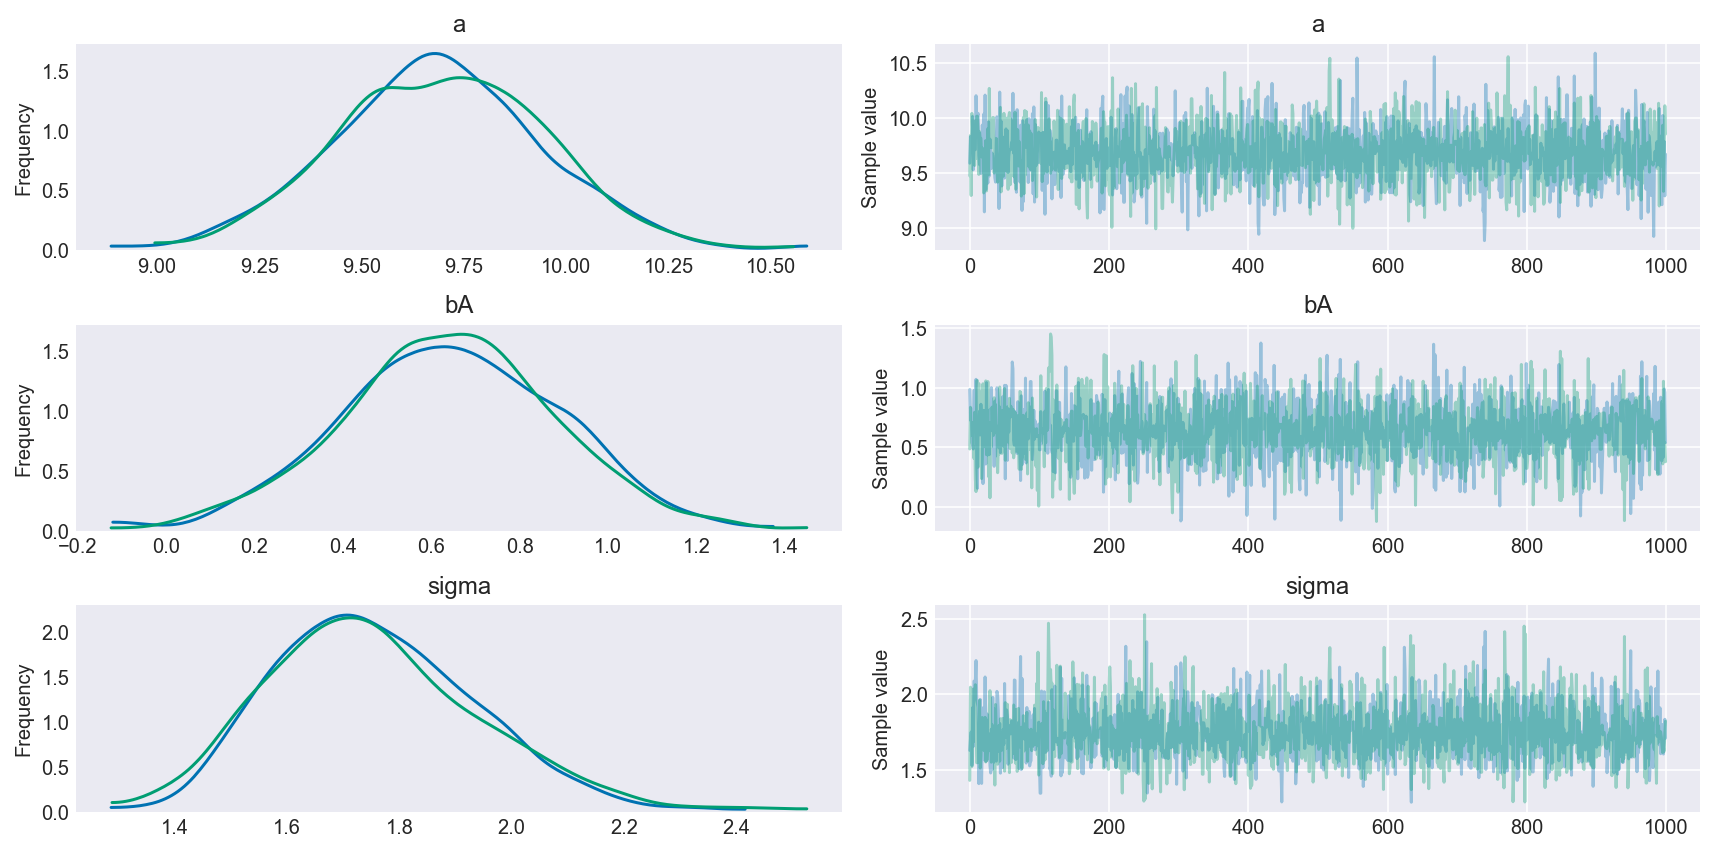

In [8]:
pm.traceplot(trace_5_2, varnames);

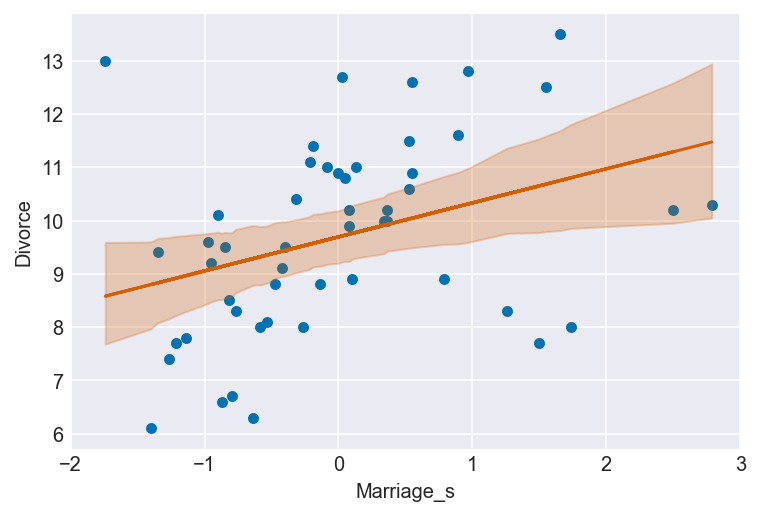

In [9]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx],
                 color='C2', alpha=0.25);

#### Code 5.4

In [10]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 400.09it/s]


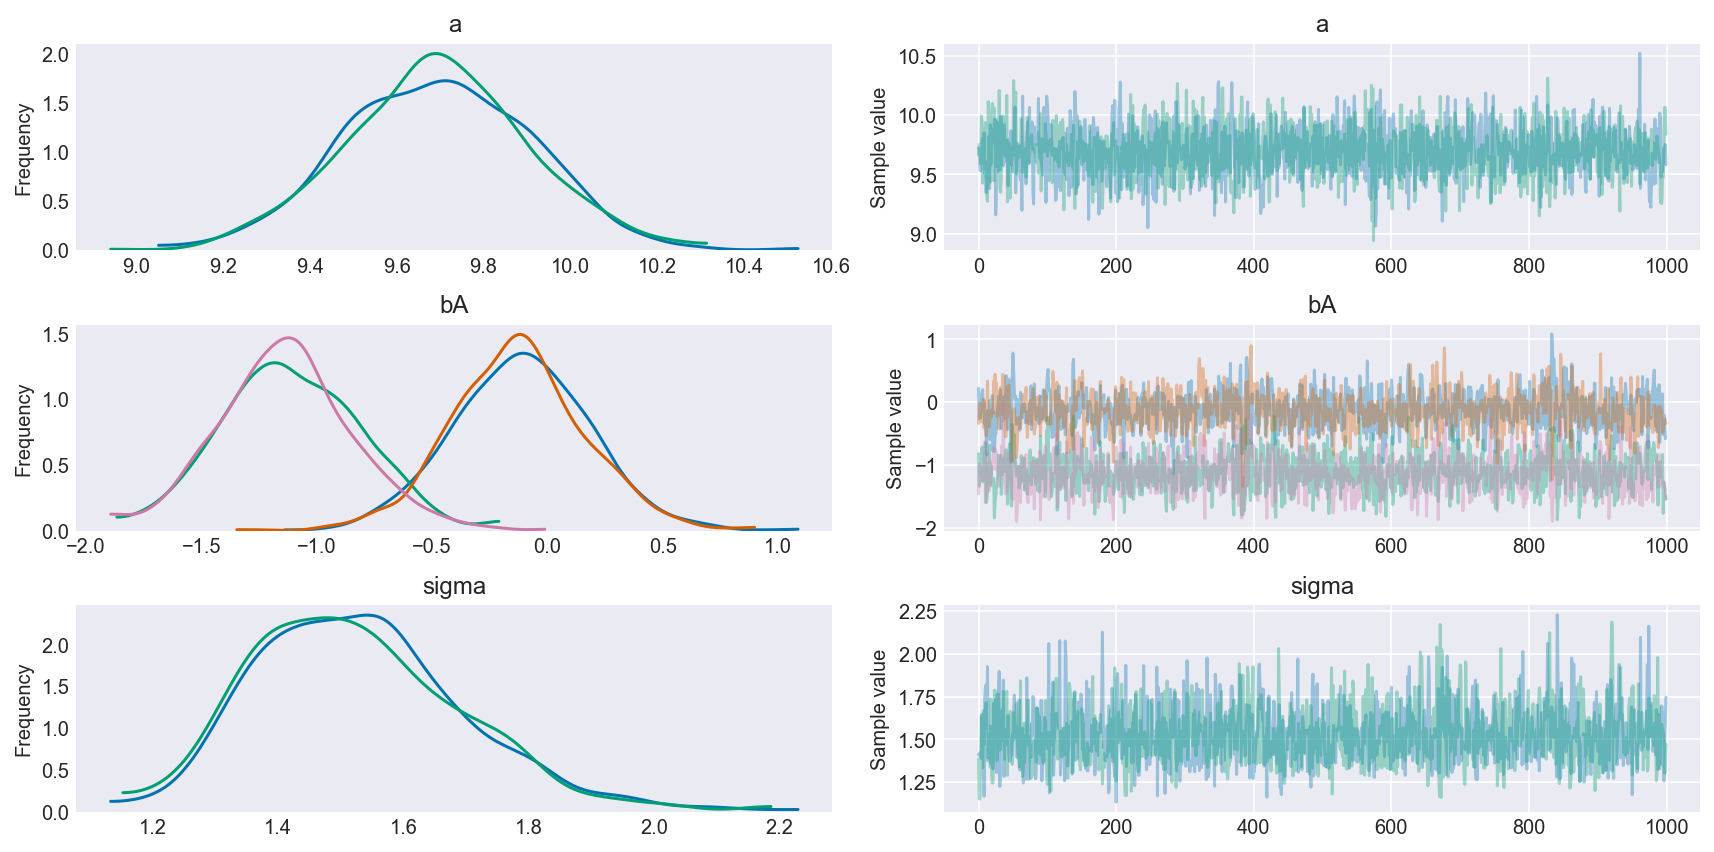

In [11]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [12]:
pm.summary(trace_5_3, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.693,0.210,0.004,9.376,10.043,1986.0,1.000
bA__0,-0.123,0.293,0.009,-0.577,0.338,1083.0,1.000
bA__1,-1.124,0.294,0.009,-1.576,-0.639,1075.0,1.002
sigma,1.527,0.167,0.004,1.277,1.783,1504.0,1.000


#### Code 5.5

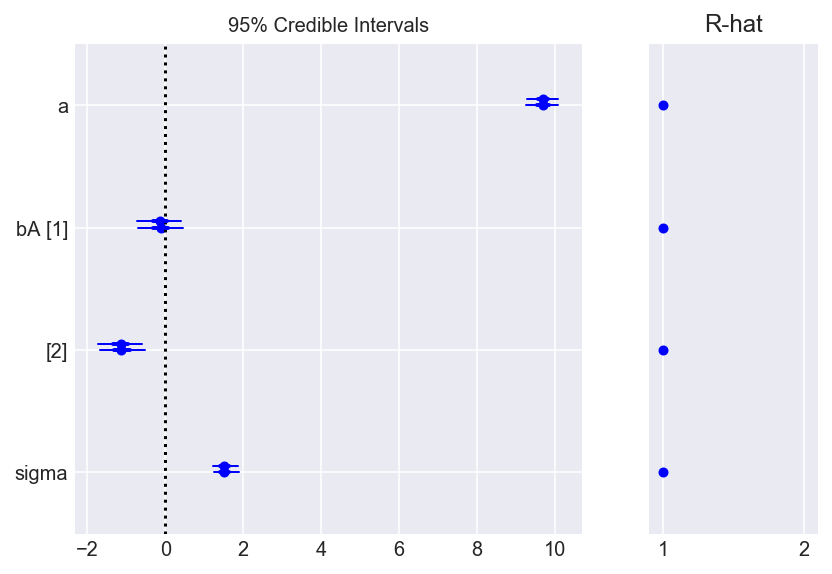

In [13]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [14]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 661.90it/s]


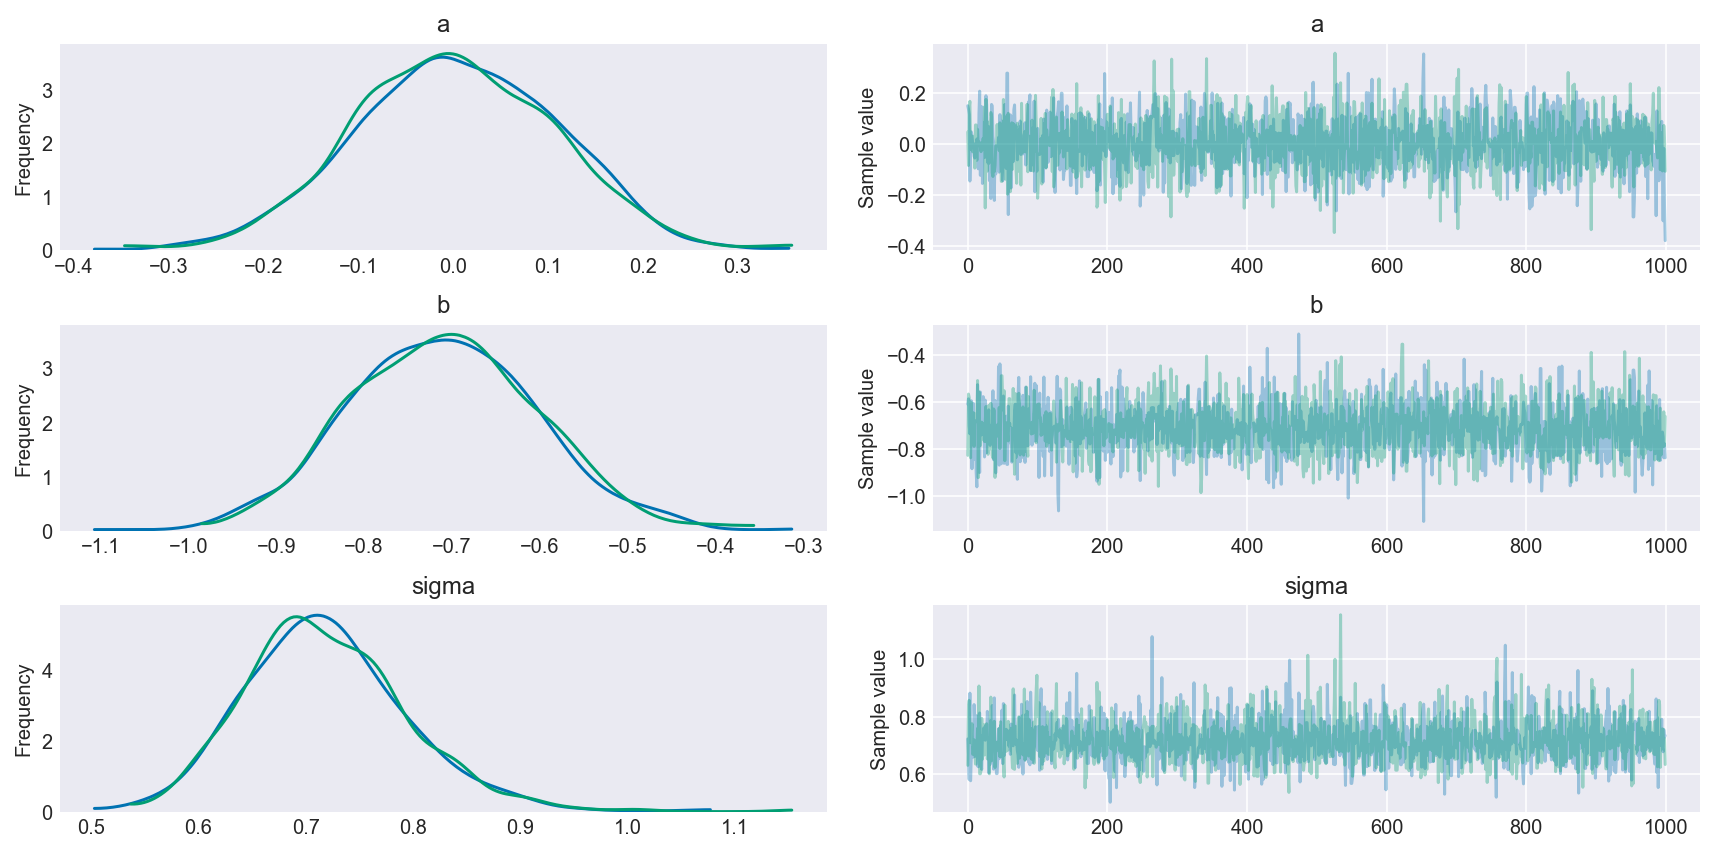

In [15]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [16]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

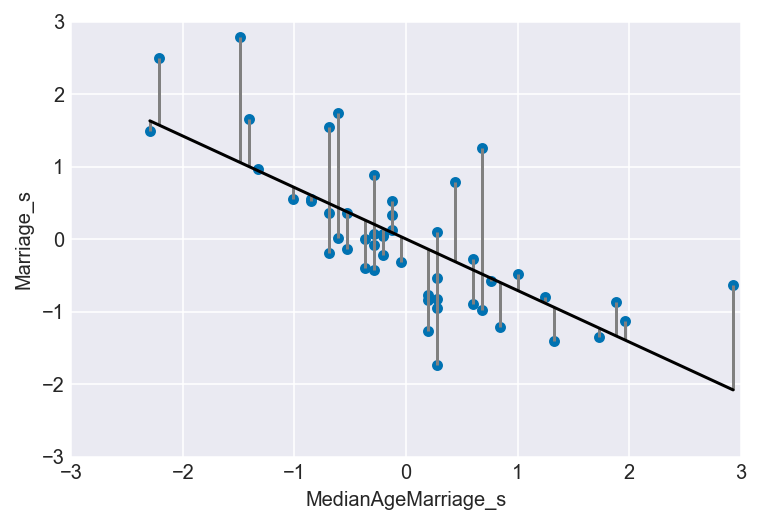

In [17]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

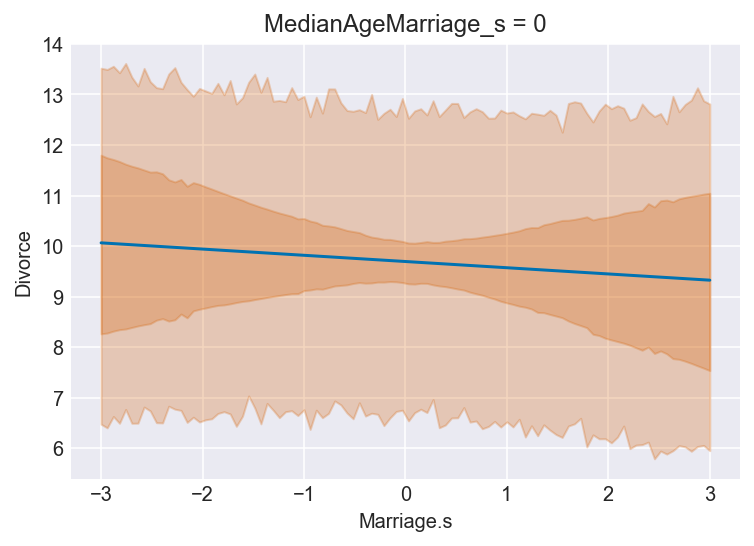

In [18]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

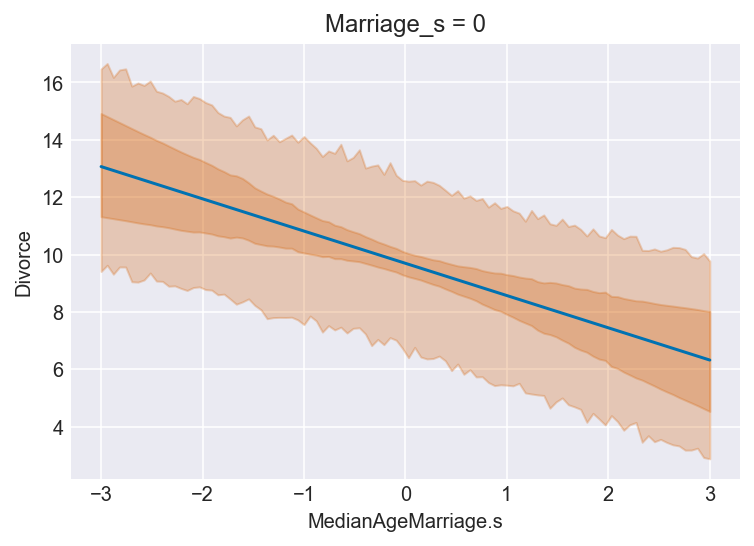

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [20]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:00<00:00, 1159.47it/s]


#### Code 5.12

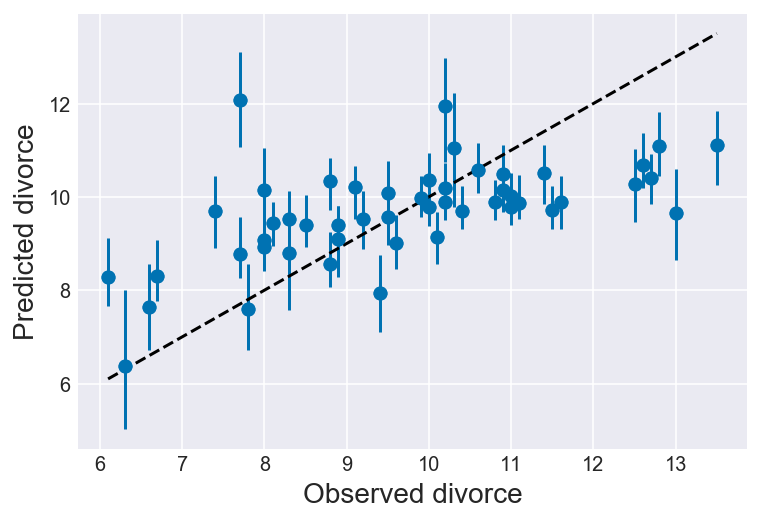

In [21]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

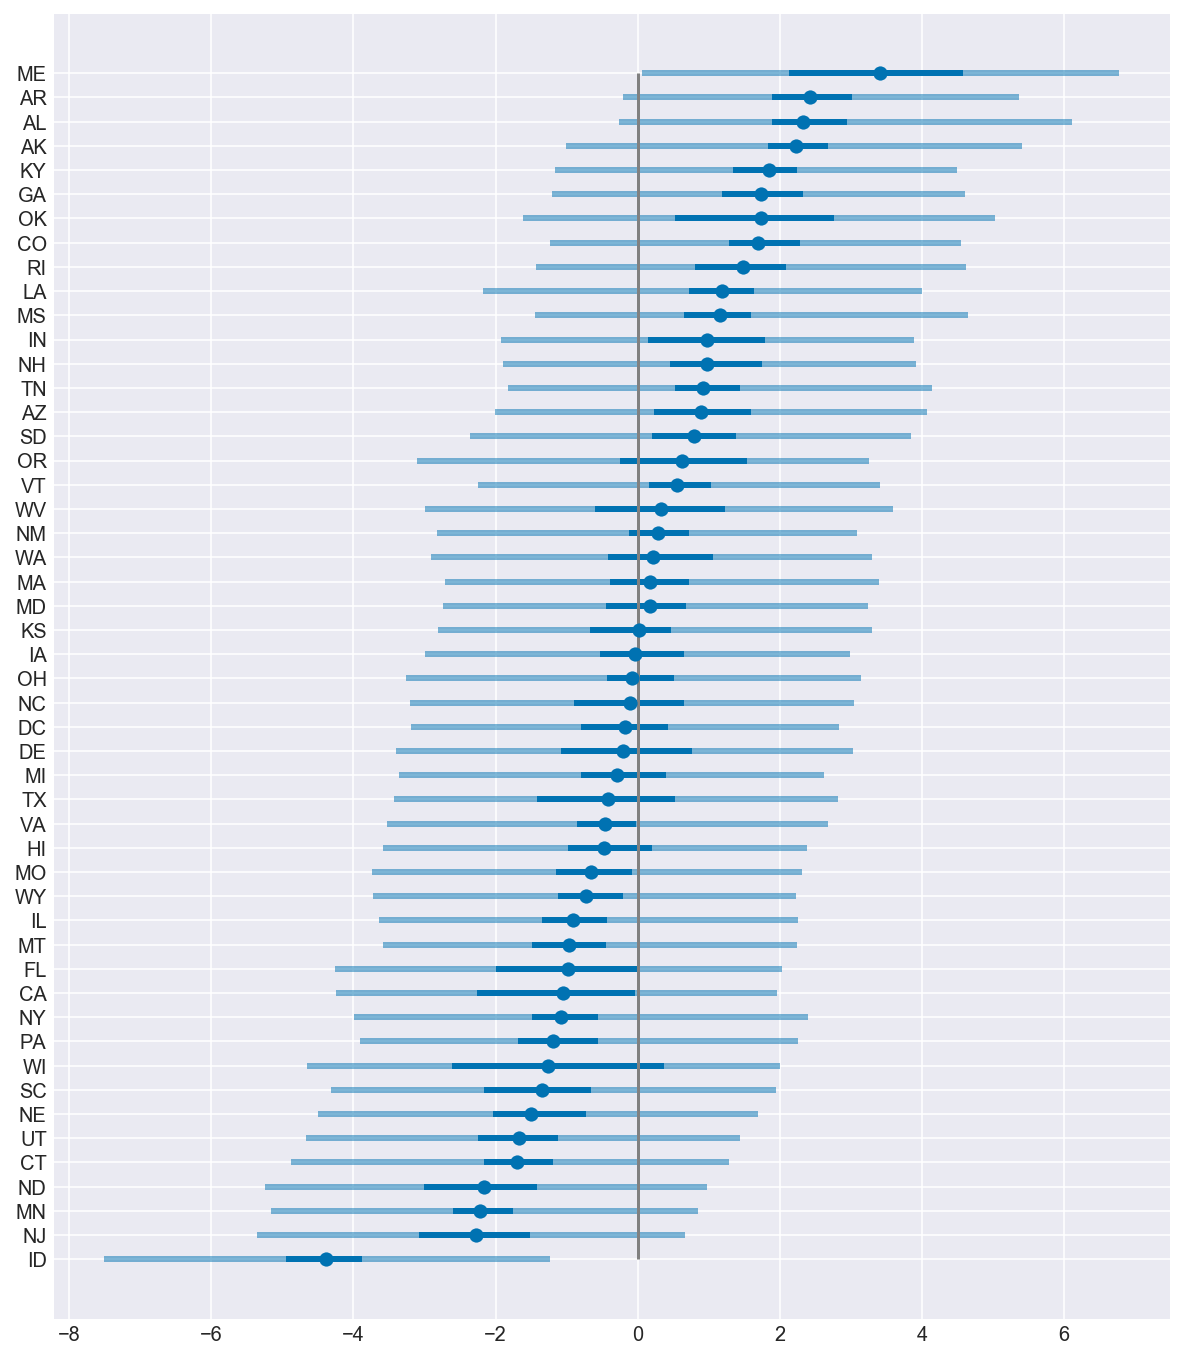

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

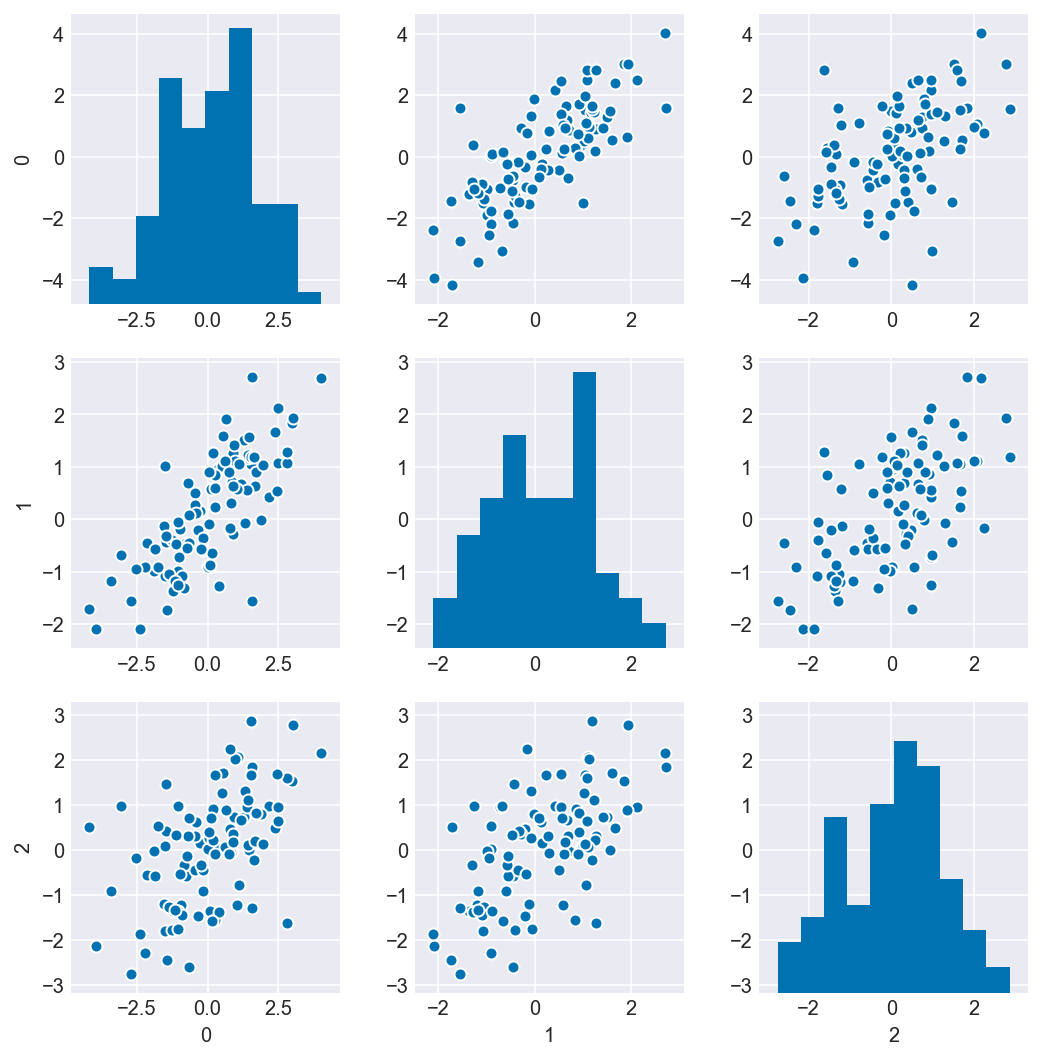

In [23]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [24]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.17 to 5.20

In [25]:
dcc = d.dropna().copy()

In [26]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1996/2000 [00:27<00:00, 136.14it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.706925573161, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 6 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [00:27<00:00, 72.69it/s] 


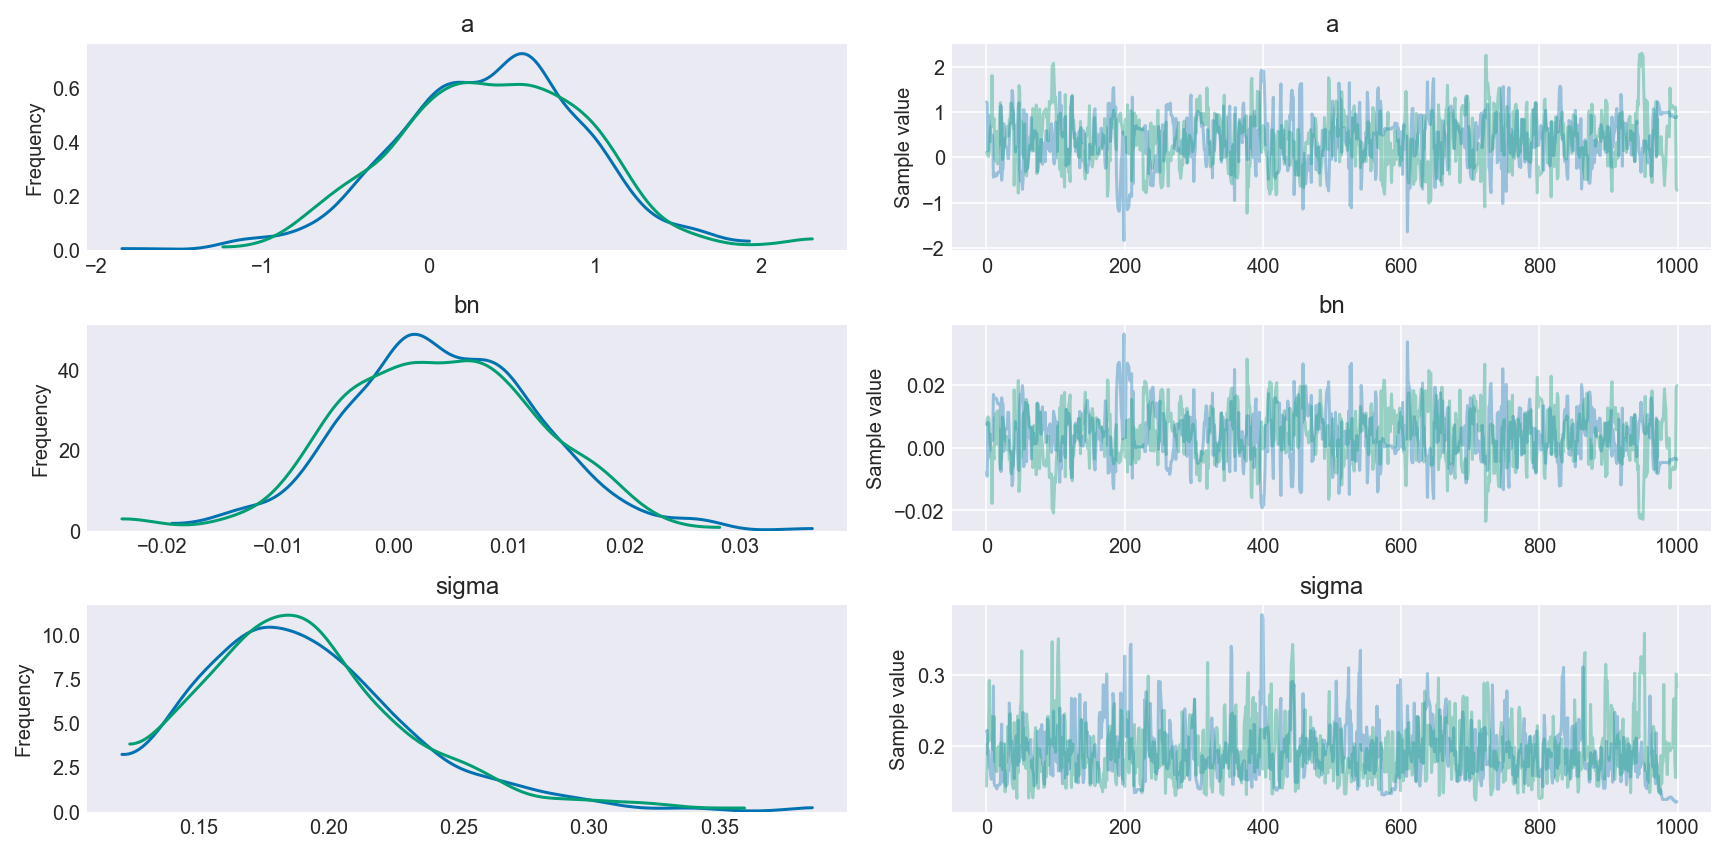

In [27]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [28]:
pm.summary(trace_5_5, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.383,0.568,0.026,-0.525,1.212,405.0,1.0
bn,0.004,0.008,0.000,-0.008,0.017,408.0,1.0
sigma,0.192,0.040,0.002,0.130,0.248,416.0,1.0


#### Code 5.22

In [29]:
trace_5_5['bn'].mean() * (76 - 55)

0.085129423377326319

#### Code 5.23

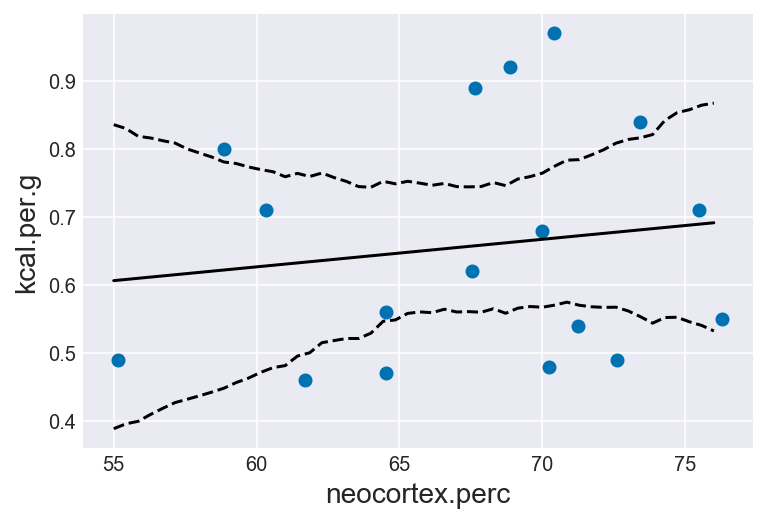

In [30]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

#### Code 5.24

In [31]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [32]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:05<00:00, 364.97it/s]


In [33]:
pm.summary(trace_5_6, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.704,0.055,0.002,0.618,0.791,683.0,1.002
bn,-0.031,0.023,0.001,-0.068,0.005,895.0,1.000
sigma,0.181,0.036,0.001,0.126,0.234,1143.0,1.000


#### Code 5.26

In [34]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 95%|█████████▌| 1906/2000 [00:34<00:01, 67.09it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [00:35<00:00, 55.59it/s]


In [35]:
pm.summary(trace_5_7, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.082,0.559,0.024,-1.895,-0.139,534.0,1.008
bn__0,0.028,0.009,0.000,0.014,0.041,529.0,1.008
bn__1,-0.096,0.027,0.001,-0.138,-0.055,609.0,1.011
sigma,0.137,0.029,0.001,0.093,0.176,703.0,1.001


#### Code 5.27

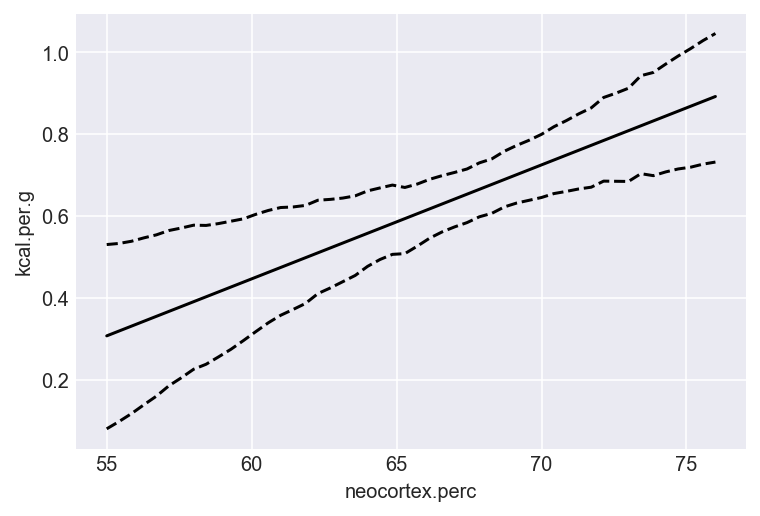

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

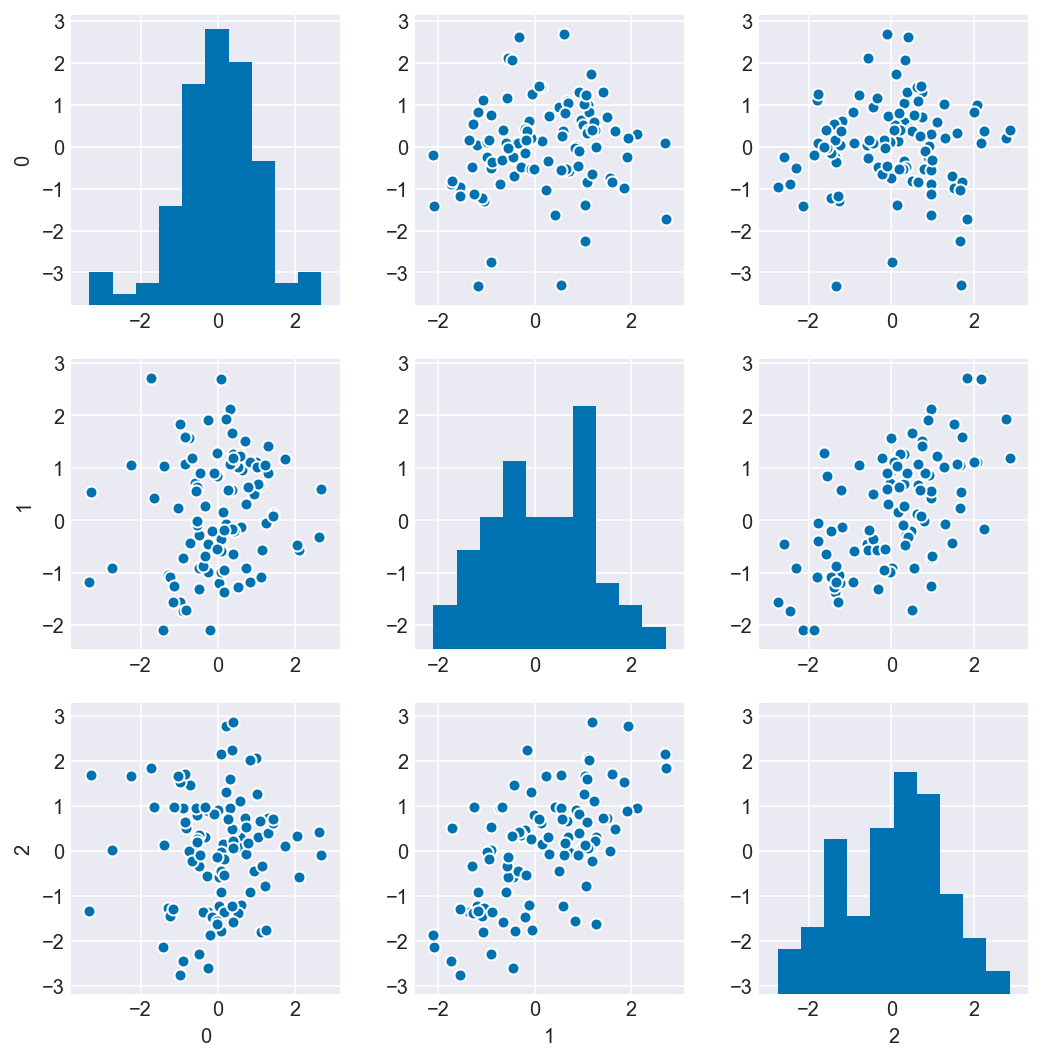

In [37]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [38]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [39]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [04:52<00:00,  6.03it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.958,0.473,0.013,5.163,6.669,1117.0,1.001
bl,-4.678,4.315,0.158,-11.207,2.363,694.0,1.000
br,5.342,4.317,0.158,-1.694,11.888,693.0,1.000
sigma,1.509,0.108,0.003,1.340,1.679,1348.0,1.000


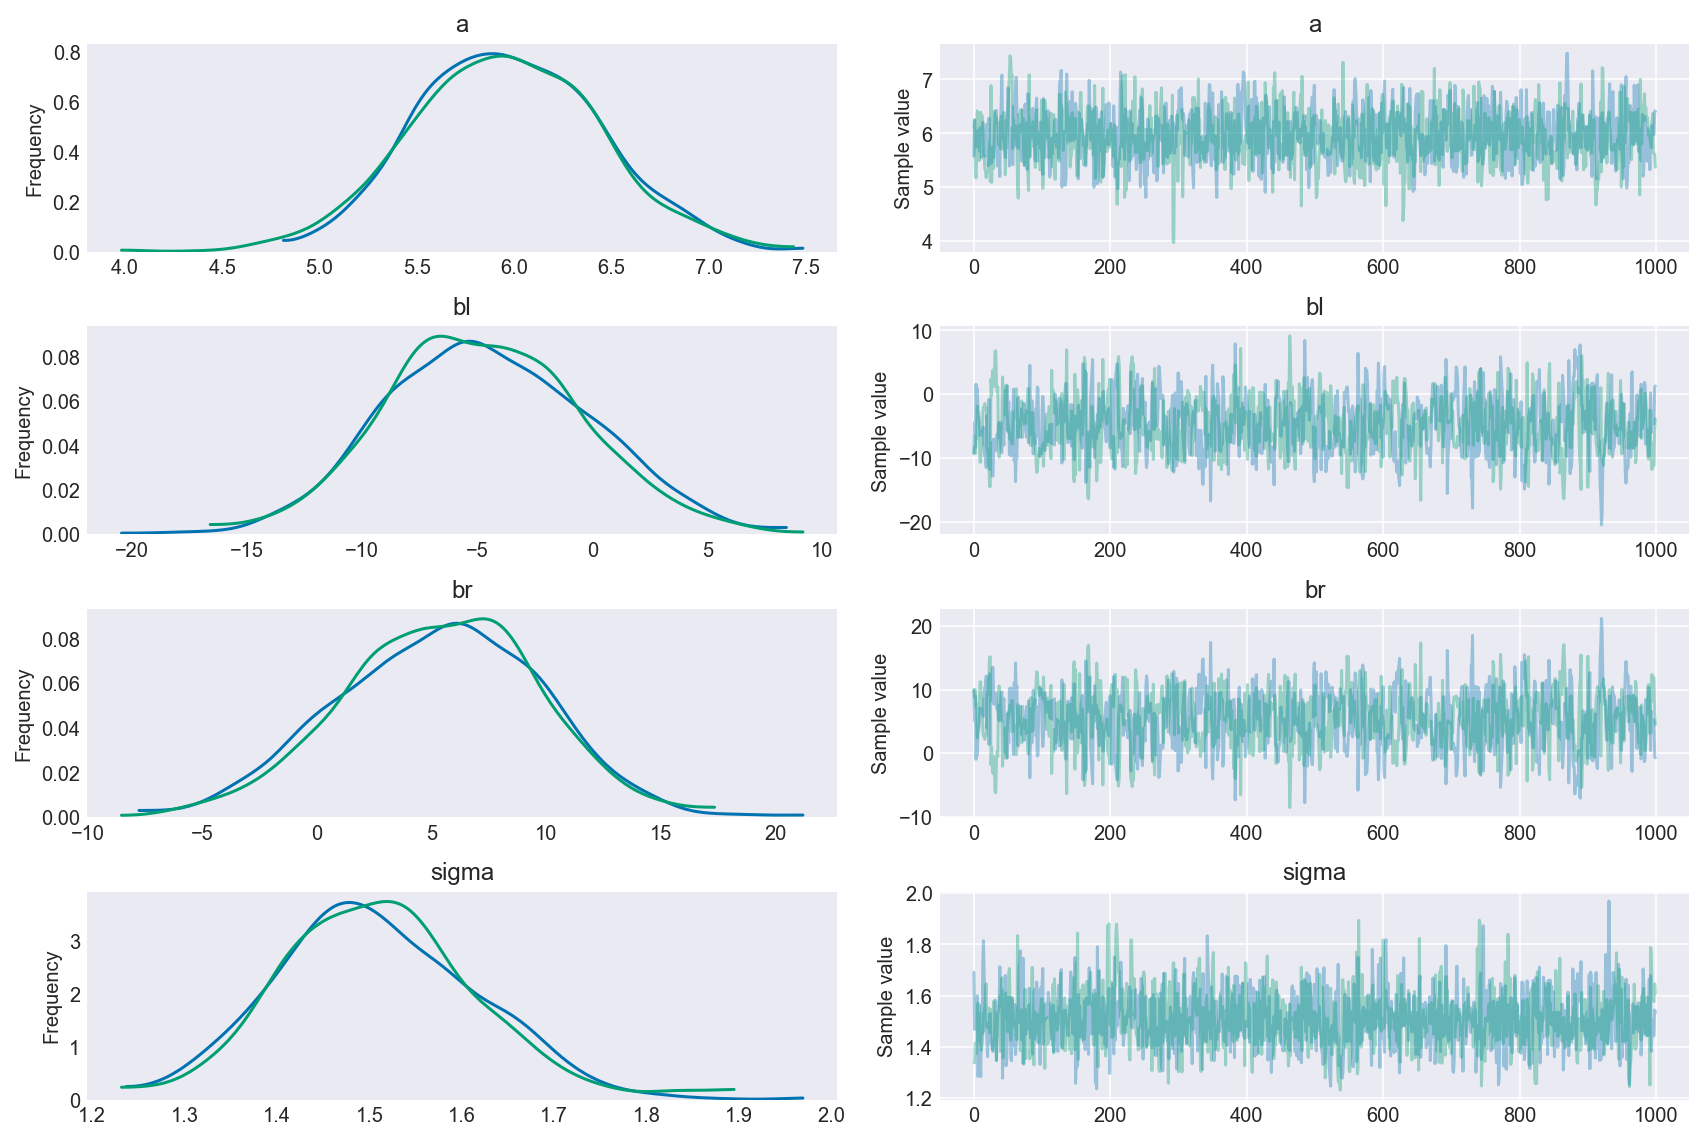

In [40]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

#### Code 5.31

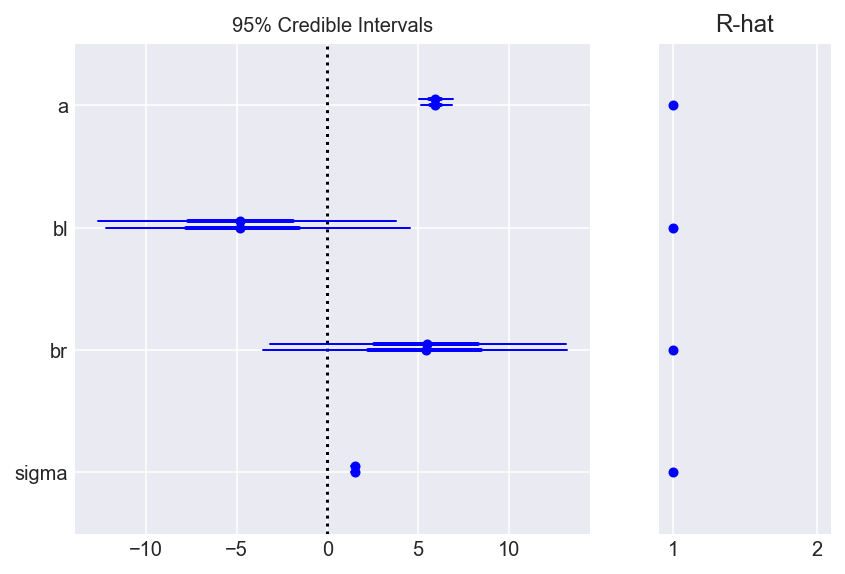

In [41]:
pm.forestplot(trace_5_8, varnames);

#### Code 5.32

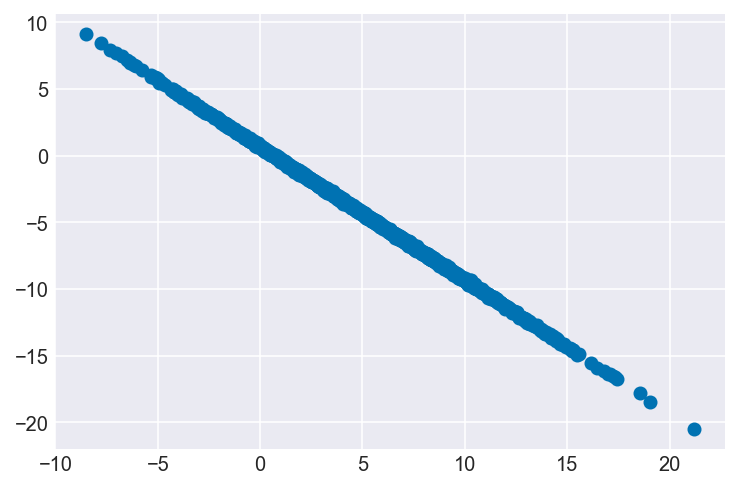

In [42]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

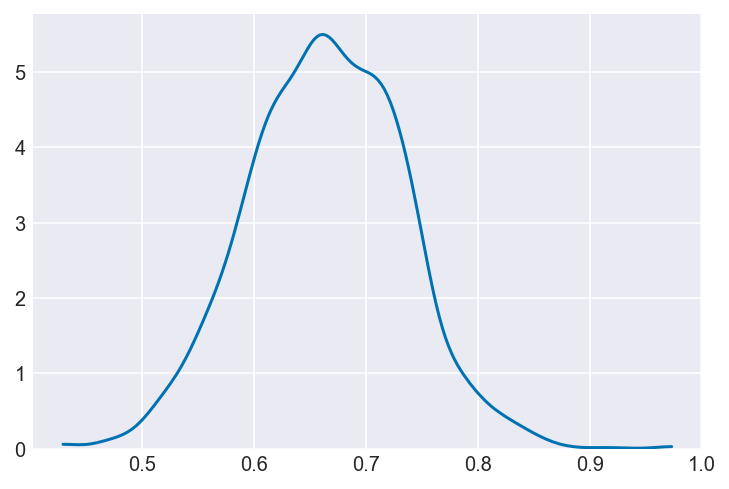

In [43]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

#### Code 5.34

In [44]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:08<00:00, 241.71it/s]


In [45]:
varnames_1 = ['a', 'bl', 'sigma']
#pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.998,0.474,0.015,5.222,6.750,804.0,1.0
bl,0.657,0.070,0.002,0.548,0.769,829.0,1.0
sigma,1.527,0.110,0.003,1.348,1.691,1248.0,1.0


#### Code 5.35

In [46]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [47]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:13<00:00, 152.76it/s]


In [48]:
varnames = ['a', 'bf', 'sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.302,0.037,0.001,0.238,0.355,902.0,1.000
bf,0.010,0.001,0.000,0.008,0.012,919.0,1.000
sigma,0.079,0.012,0.000,0.060,0.095,947.0,1.001


In [49]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:12<00:00, 163.51it/s]


In [50]:
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.165,0.045,0.002,1.098,1.239,608.0,1.000
bl,-0.011,0.001,0.000,-0.012,-0.009,800.0,1.000
sigma,0.067,0.010,0.000,0.053,0.082,966.0,1.001


#### Code 5.37

In [51]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1995/2000 [00:39<00:00, 58.73it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [00:39<00:00, 50.72it/s]


In [52]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.003,0.226,0.008,0.664,1.378,534.0,1.002
bf,0.002,0.003,0.000,-0.002,0.007,567.0,1.003
bl,-0.009,0.003,0.000,-0.013,-0.004,535.0,1.002
sigma,0.068,0.010,0.000,0.053,0.084,565.0,1.000


#### Code 5.38

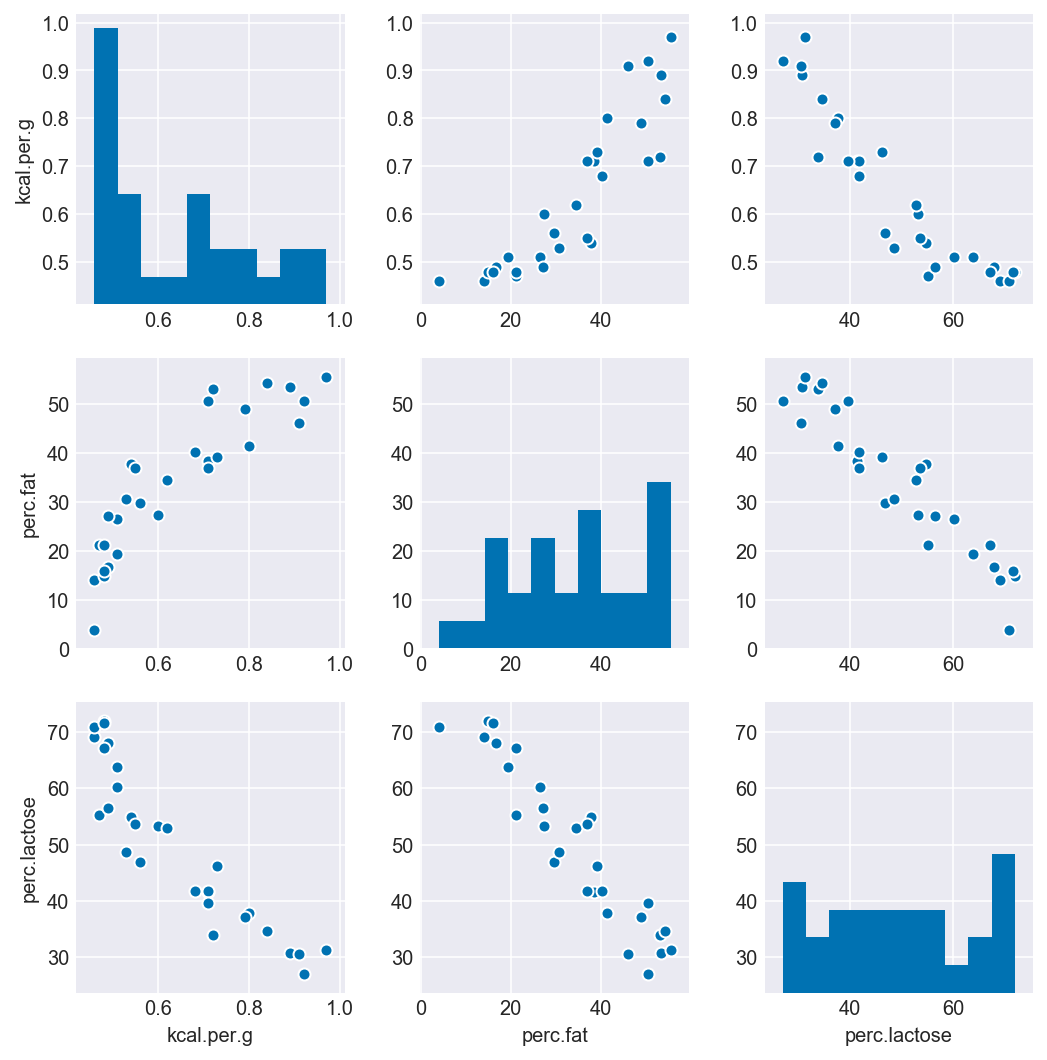

In [53]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [54]:
milk.corr()['perc.fat']['perc.lactose']

-0.94163734568392821

#### Code 5.40

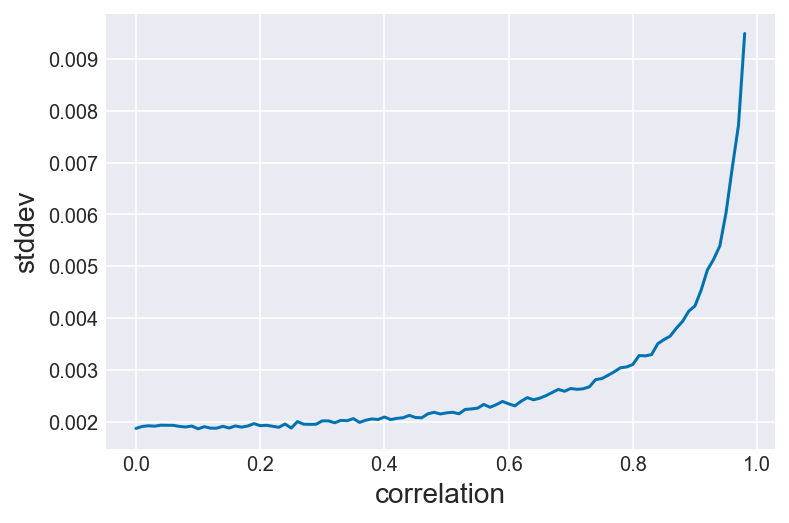

In [55]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 5.41

In [56]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

#### Code 5.42

In [57]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:24<00:00, 80.42it/s] 


In [58]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.050,0.459,0.014,4.295,5.746,837.0,1.0
bh,0.999,0.044,0.001,0.931,1.069,874.0,1.0
bt,-0.208,0.217,0.006,-0.537,0.154,1265.0,1.0
bf,-2.873,0.245,0.006,-3.274,-2.480,1334.0,1.0
sigma,0.942,0.069,0.002,0.828,1.049,1340.0,1.0


#### Code 5.43

In [59]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:21<00:00, 104.27it/s]


In [60]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.940,0.716,0.023,2.869,5.161,1052.0,1.000
bh,0.966,0.070,0.002,0.838,1.066,1058.0,1.000
bt,1.062,0.290,0.007,0.623,1.566,1775.0,1.000
sigma,1.482,0.104,0.002,1.313,1.640,1599.0,1.001


#### Code 5.44

In [61]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 5.45

In [62]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:08<00:00, 249.25it/s]


In [63]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.836,1.615,0.052,131.966,137.136,1057.0,1.0
bm,7.246,2.303,0.076,3.389,10.681,966.0,1.0
sigma,27.414,0.823,0.021,26.056,28.636,1480.0,1.0


#### Code 5.46

In [64]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

array([ 138.85086353,  145.49554967])

#### Code 5.47

In [65]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:06<00:00, 327.64it/s]


#### Code 5.48

In [66]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [67]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

#### Code 5.50

In [68]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

#### Code 5.51

In [69]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])
    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:06<00:00, 300.11it/s]


In [70]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.545,0.044,0.001,0.476,0.615,963.0,1.004
b_NWM,0.171,0.062,0.002,0.073,0.266,1160.0,1.003
b_OWM,0.242,0.068,0.002,0.128,0.342,1131.0,1.001
b_S,-0.041,0.072,0.002,-0.151,0.078,1079.0,1.002
sigma,0.130,0.019,0.000,0.098,0.155,1456.0,1.000


#### Code 5.52

In [71]:
varnames = ['mu_ape', 'mu_NWM', 'b_OWM', 'b_S']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]

,mean,sd,hpd_5.5,hpd_94.5
mu_ape,0.545,0.044,0.476,0.615
mu_NWM,0.716,0.042,0.650,0.784
b_OWM,0.242,0.068,0.128,0.342
b_S,-0.041,0.072,-0.151,0.078


#### Code 5.53

In [72]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.20010132883302803, -0.070189857841745529, 0.064217353005757746)

#### Code 5.54

In [73]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [74]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10)
    mu = pm.Deterministic('mu', a)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:02<00:00, 760.40it/s]


In [75]:
varnames = ['mu', 'sigma']
pm.summary(trace_5_16_alt, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,0.642,0.033,0.001,0.593,0.698,1966.0,1.0
sigma,0.170,0.024,0.001,0.133,0.206,1278.0,1.0


The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [76]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

In [77]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.3
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.1.0
Seaborn 0.8.0

